In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-01-28 17:39:13.506006: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-28 17:39:13.696150: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-28 17:39:14.433363: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

In [2]:
MEMORY = 8*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 

1 Physical GPUs, 1 Logical GPUs


2023-01-28 17:39:22.010899: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-28 17:39:22.757961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8192 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:e3:00.0, compute capability: 8.6


In [3]:
sys.path.append("/end/home/rh2310/morpho_repo")
sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

In [4]:
from local_utils import *

# Load Koch Meinhardt dataset


In [5]:
x_slice=slice(30,65,1)
y_slice=slice(50,85,1)
pattern = load("Koch_Meinhardt_6", x_slice, y_slice)

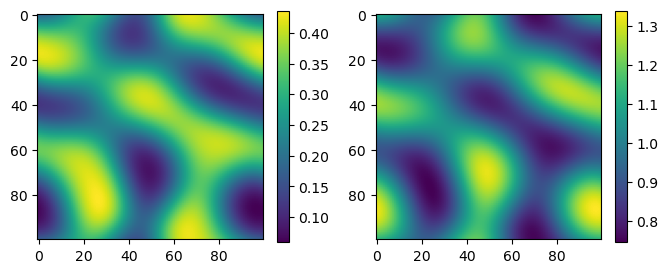

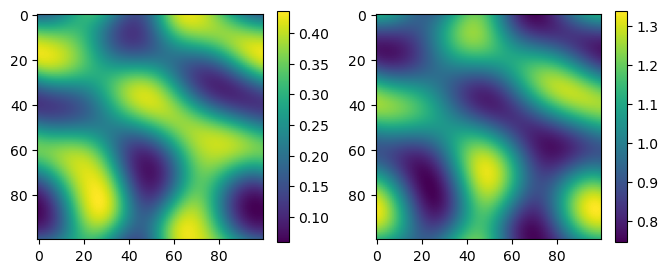

In [6]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(pattern.c_domain[0,:,:, 0])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(pattern.c_domain[1,:,:, 0])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(pattern.c_domain[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(pattern.c_domain[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

In [7]:
lb = pattern.dataset['lb']
ub = pattern.dataset['ub']

obs_inputs = pattern.dataset['obs_input']
obs_outputs = pattern.dataset['obs_output']
obs_X = np.concatenate([obs_inputs, obs_outputs], axis=1)
pde_X = obs_inputs

In [8]:
ds = TINN_Dataset(tf.float32, obs_X, pde_X)

In [9]:
ds.sizes

array([2450, 2450])

In [10]:
#layers = [3, 512, 512, 512, 512, 512, 2]
layers = [3, 128, 128, 128, 128, 128, 2]

obs_loss = Observation_Loss(layers,regularise=True, loss_grad_type=  Loss_Grad_Type.PINN)

In [11]:
pinnKM = tu.NN(layers, lb, ub, dtype=tf.float32)

#pbc_loss = Periodic_Boundary_Condition(regularise=True)

modelKM = tu.TINN_Inverse(pinnKM, 
                  losses= [ obs_loss],
                  norm = L2(),
                  optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-4), #keras.optimizers.Adam(learning_rate=5e-4),
                  alpha = 0.9, 
                  loss_penalty_power = 3,
                  print_precision=".12f")

In [19]:
#for element in obs_X[:,:2]:#ds:
    #print(pinnKM.net(element[0][:2]))
#print(pinnKM.net(obs_X[:,:2].astype(np.float32)).numpy())
#print(obs_X[:,2:])
#print(np.abs(pinnKM.net(obs_X[:,:2].astype(np.float32)).numpy() - obs_X[:,2:]))
print(np.max(np.abs(pinnKM.net(obs_X[:,:3].astype(np.float32)).numpy() - obs_X[:,3:])))
print(np.mean(np.abs(pinnKM.net(obs_X[:,:3].astype(np.float32)).numpy() - obs_X[:,3:])))
print()
print(np.mean((pinnKM.net(obs_X[:,:3].astype(np.float32)).numpy()[:,0] - obs_X[:,3])**2))
print(np.mean((pinnKM.net(obs_X[:,:3].astype(np.float32)).numpy()[:,1] - obs_X[:,4])**2))

0.027565734195737157
0.0022634265690237424

8.704121743368482e-06
9.841550876344449e-06


In [13]:
results_KM = modelKM.train(epochs = 10000+1,
                          batch_size = 2450//2,
                          dataset = ds,
                          print_interval=1000,
                          stop_threshold = 1e-12,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=100)


Start of epoch 0
total loss: 2.542245745659, total regularised loss: 2.542245864868
Observation_Loss -> 
(1)  obs u: 0.119319729507 (2)  obs v: 1.151803165674 
Time taken: 2.87s

Start of epoch 1000
total loss: 0.000412656911, total regularised loss: 0.000412656926
Observation_Loss -> 
(1)  obs u: 0.000061167400 (2)  obs v: 0.000145161059 
Time taken: 28.98s

Start of epoch 2000
total loss: 0.000357186327, total regularised loss: 0.000357186334
Observation_Loss -> 
(1)  obs u: 0.000032606617 (2)  obs v: 0.000145986549 
Time taken: 29.68s

Start of epoch 3000
total loss: 0.000485934768, total regularised loss: 0.000485934783
Observation_Loss -> 
(1)  obs u: 0.000049308119 (2)  obs v: 0.000193659274 
Time taken: 28.94s

Start of epoch 4000
total loss: 0.000287108822, total regularised loss: 0.000287108822
Observation_Loss -> 
(1)  obs u: 0.000054434400 (2)  obs v: 0.000089120014 
Time taken: 29.24s

Start of epoch 5000
total loss: 0.000103472215, total regularised loss: 0.000103472215
O

In [15]:
results_KM = modelKM.train(epochs = 10000+1,
                          batch_size = 2450//2,
                          dataset = ds,
                          print_interval=1000,
                          stop_threshold = 4e-4,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=100)


Start of epoch 0
total loss: 0.000053796657, total regularised loss: 0.000053796655
Observation_Loss -> 
(1)  obs u: 0.000009564743 (2)  obs v: 0.000017333586 
############################################
#               Early stop                 #
############################################


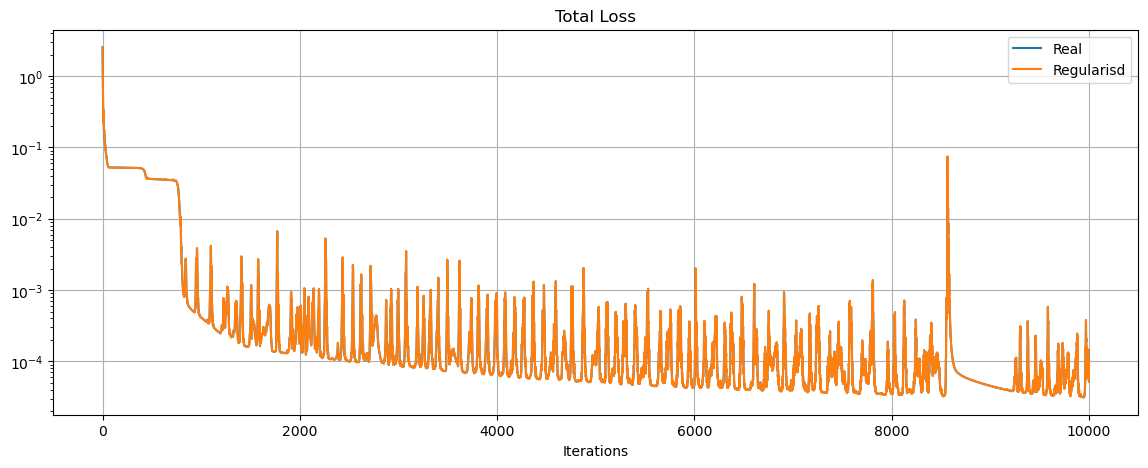

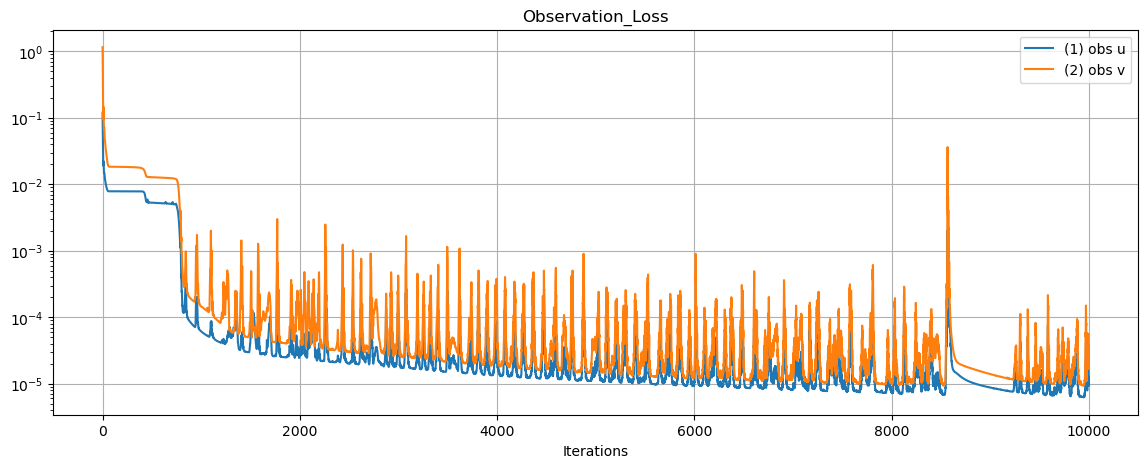

In [14]:
plot_result(merge_dict(results_KM,), modelKM, start=0)

In [16]:
pinnKM.save(".", "Koch_Meinhardt_6_pinn_step_1")
#pinnKM = tu.NN.restore(".", "pinn")

In [17]:
@tf.function
def derivatives(pinn, x):
    return obs_loss.derivatives(pinn, x)

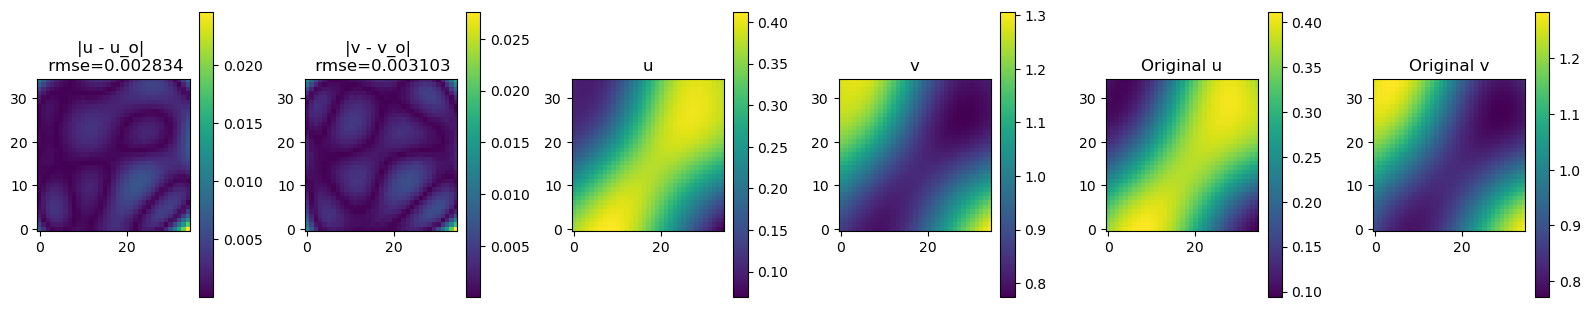

In [18]:
block_x = pattern.block_x
block_y = pattern.block_y
block_size = block_x * block_y

def p(m1, m2, m3, m4, t1="u", t2="v"):
    _ = plt.figure(figsize=(16,6))
    plt.subplot(161)
    rmse = np.sqrt(np.mean((m1 - m3)**2))
    plt.title(f"|{t1} - {t1}_o| \n rmse={rmse:.6f}")
    plt.imshow((np.abs(m1 - m3)), origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(162)
    rmse = np.sqrt(np.mean((m2 - m4)**2))
    plt.title(f"|{t2} - {t2}_o| \n rmse={rmse:.6f}")
    plt.imshow((np.abs(m2 - m4)), origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(163)
    plt.title(f"{t1}")
    plt.imshow(m1, origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(164)
    plt.title(f"{t2}")
    plt.imshow(m2, origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(165)
    plt.title(f"Original {t1}")
    plt.imshow(m3, origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(166)
    plt.title(f"Original {t2}")
    plt.imshow(m4, origin='lower')
    plt.colorbar(shrink=.5)
    plt.tight_layout()
    plt.show()


test_d = obs_X[:,:3].astype(np.float32)
y, u,  u_xx, u_yy, u_t, v,  v_xx, v_yy, v_t = derivatives(pinnKM, test_d)
# D_u = pde_resKM.D_u.get_value(test_d)
# D_v = pde_resKM.D_v.get_value(test_d)
# sigma_u = pde_resKM.sigma_u.get_value(test_d) #/ pde_resKM.alpha_u
# sigma_v = pde_resKM.sigma_v.get_value(test_d) #/ pde_resKM.alpha_v
# mu_u = pde_resKM.mu_u.get_value(test_d)
# rho_u = pde_resKM.rho_u.get_value(test_d) ##* pde_resKM.alpha_u * pde_resKM.alpha_v
# rho_v = pde_resKM.rho_v.get_value(test_d) #* pde_resKM.alpha_u * pde_resKM.alpha_u
# kappa_u = pde_resKM.kappa_u.get_value(test_d)

def as_patch(m):
    if isinstance(m, np.ndarray):
        return m[block_size:].reshape(block_x, block_y).T
    else:
        return m.numpy()[block_size:].reshape(block_x, block_y).T

u = as_patch(u)
v = as_patch(v)
u_xx = as_patch(u_xx)
v_xx = as_patch(v_xx)
u_yy = as_patch(u_yy)
v_yy = as_patch(v_yy)
u_t = as_patch(u_t)
v_t = as_patch(v_t)

u_obs = as_patch(obs_X[:,3])
v_obs = as_patch(obs_X[:,4])
#u_xx_obs = as_patch(der_u_outputs[:,0])
#u_yy_obs = as_patch(der_u_outputs[:,1])
#u_t_obs = as_patch(der_u_outputs[:,2])
#v_xx_obs = as_patch(der_v_outputs[:,0])
#v_yy_obs = as_patch(der_v_outputs[:,1])
#v_t_obs = as_patch(der_v_outputs[:,2])


p(u, v, u_obs, v_obs)
#p(u_xx, u_yy, u_xx_obs, u_yy_obs,"u_xx", "u_yy")
#p(v_xx, v_yy, v_xx_obs, v_yy_obs,"v_xx", "v_yy")
#p(diff_u, diff_v, diff_u_obs, diff_v_obs,r"$\nabla^2 u$", r"$\nabla^2 v$")
#p(u_t, v_t, u_t_obs, v_t_obs,"u_t", "v_t")


In [20]:
simulation = pattern.simulation
pde_resKM = Koch_Meinhard(
                    D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
                    D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT,  simulation.Ds[1], dtype=pinnKM.dtype),
                    #kappa_u=PDE_Parameter("kappa_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, zero_lb=True),
                    kappa_u=PDE_Parameter("kappa_u", Parameter_Type.CONSTANT, simulation.parameters["kappa_u"] ,dtype=pinnKM.dtype),
                    mu_u=PDE_Parameter("mu_u", Parameter_Type.VARIABLE, 1.1,dtype=pinnKM.dtype),
                    #mu_u=PDE_Parameter("mu_u", Parameter_Type.CONSTANT, simulation.parameters["mu_u"],dtype=pinnKM.dtype),
                    rho_u=PDE_Parameter("rho_u", Parameter_Type.VARIABLE, 1.1,dtype=pinnKM.dtype),
                    #rho_u=PDE_Parameter("rho_u", Parameter_Type.CONSTANT, simulation.parameters["rho_u"],dtype=pinnKM.dtype),                    
                    rho_v=PDE_Parameter("rho_v", Parameter_Type.VARIABLE, 0.125,dtype=pinnKM.dtype),                    
                    #rho_v=PDE_Parameter("rho_v", Parameter_Type.CONSTANT, simulation.parameters["rho_v"],dtype=pinnKM.dtype),                    
                    sigma_u=PDE_Parameter("sigma_u", Parameter_Type.VARIABLE, 1.1,dtype=pinnKM.dtype),
                    #sigma_u=PDE_Parameter("sigma_u", Parameter_Type.CONSTANT, simulation.parameters["sigma_u"],dtype=pinnKM.dtype),
                    sigma_v=PDE_Parameter("sigma_v", Parameter_Type.VARIABLE, 0.2,dtype=pinnKM.dtype),
                    #sigma_v=PDE_Parameter("sigma_v", Parameter_Type.CONSTANT, simulation.parameters["sigma_v"],dtype=pinnKM.dtype),
                   regularise=False,
                   loss_grad_type=  Loss_Grad_Type.PARAMETER
    )

modelKM2 = tu.TINN_Inverse(pinnKM.copy(), 
                  losses= [pde_resKM],
                  norm = L2(),
                  optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-4), #keras.optimizers.Adam(learning_rate=5e-4),
                  alpha = 0.9, 
                  loss_penalty_power = 3,
                  print_precision=".12f")
#ds = TINN_Dataset(tf.float32, obs_X, pde_X)
ds2 = TINN_Dataset(tf.float32, pde_X)


In [ ]:
results_KM2 = modelKM2.train(epochs = 1000+1,
                          batch_size = 81,
                          dataset = ds2,
                          print_interval=100,
                          stop_threshold = 1e-12,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=100)

In [15]:
simulation.parameters

{'kappa_u': 0.0,
 'mu_u': 1.0,
 'rho_u': 1.0,
 'rho_v': 0.025,
 'sigma_u': 1.0,
 'sigma_v': 0.1}

In [16]:
import pathlib
import pickle

In [19]:
path = pathlib.PurePath("/end/home/rh2310/morpho_repo/Loss_landscape").joinpath("Koch_Meinhardt_2_results")
with open(f"{str(path)}_data.pkl", "wb") as f:
    pickle.dump(results_KM2, f)

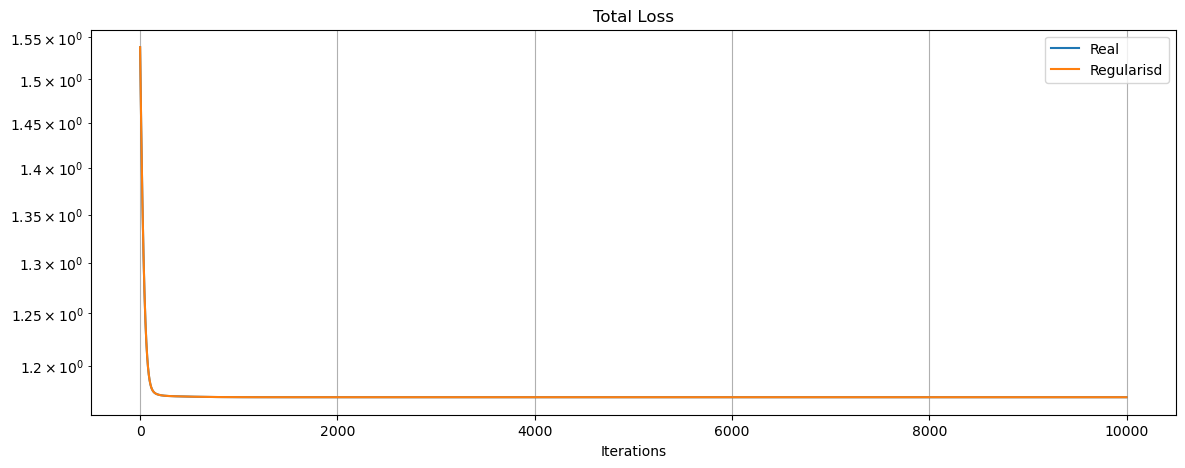

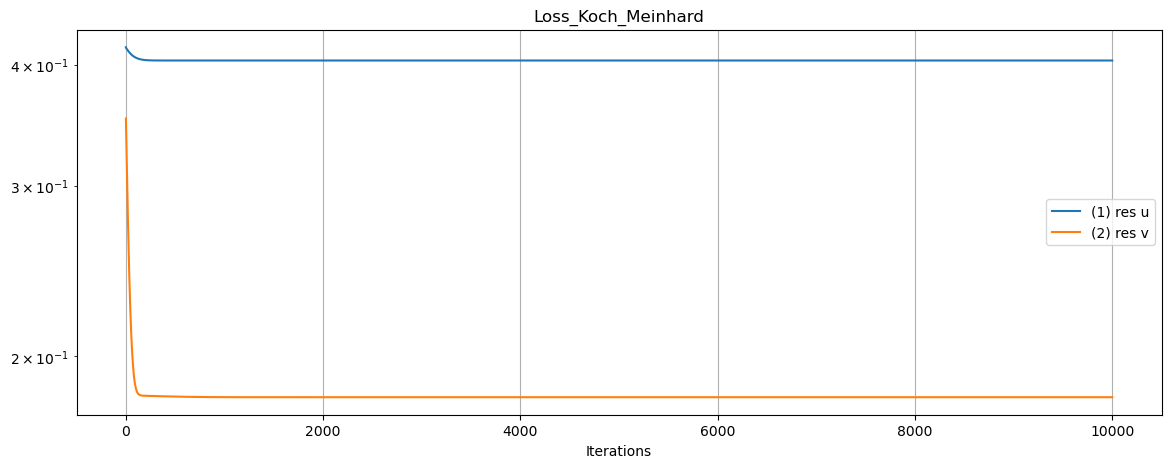

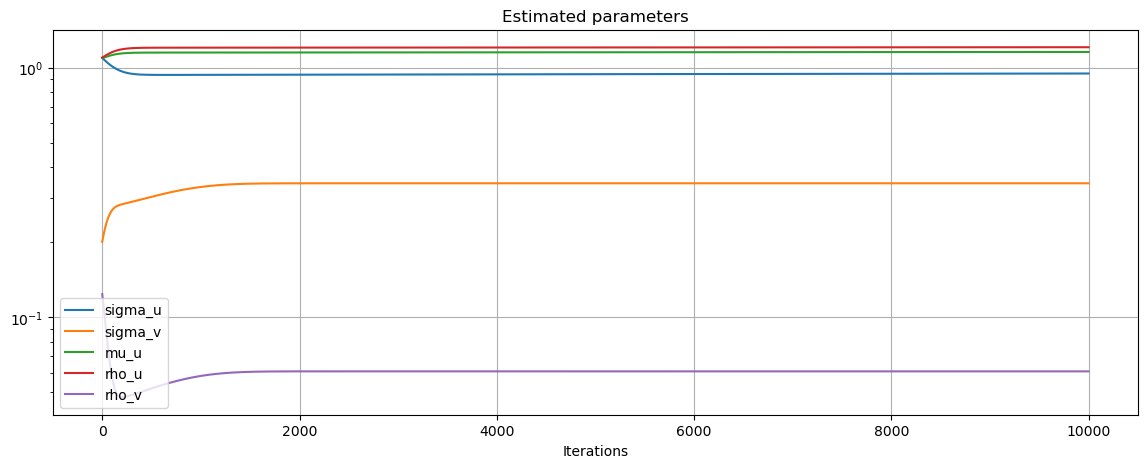

In [27]:
plot_result(merge_dict(results_KM2,), modelKM2, start=0, 
            param_names=pde_resKM.parameter_names())

In [22]:
def norm_params(pde_resKM, simulation):
    #D_u = pde_resKM.D_u.get_value(test_d)
    #D_v = pde_resKM.D_v.get_value(test_d)
    sigma_u = (pde_resKM.sigma_u.get_value(test_d) / pde_resKM.alpha_u).numpy()
    sigma_v = (pde_resKM.sigma_v.get_value(test_d) / pde_resKM.alpha_v).numpy()
    mu_u = (pde_resKM.mu_u.get_value(test_d)).numpy()
    rho_u = (pde_resKM.rho_u.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_v).numpy()
    rho_v = (pde_resKM.rho_v.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_u).numpy()
    kappa_u = (pde_resKM.kappa_u.get_value(test_d) * pde_resKM.alpha_u * pde_resKM.alpha_u).numpy()
    
    sigma_u2 = simulation.parameters["sigma_u"]
    sigma_v2 = simulation.parameters["sigma_v"]
    mu_u2 = simulation.parameters["mu_u"]
    rho_u2 = simulation.parameters["rho_u"]
    rho_v2 = simulation.parameters["rho_v"]
    kappa_u2 = simulation.parameters["kappa_u"]
    
    return ((sigma_u-sigma_u2)**2 + (sigma_v-sigma_v2)**2 +(mu_u-mu_u2)**2 +
            (rho_u-rho_u2)**2 + (rho_v-rho_v2)**2 +(kappa_u-kappa_u2)**2
           )
    
def norm_params2(result, simulation):
    #D_u = pde_resKM.D_u.get_value(test_d)
    #D_v = pde_resKM.D_v.get_value(test_d)
    sigma_u = result["sigma_u"] if "sigma_u" in result.keys() else simulation.parameters["sigma_u"]
    sigma_v =  result["sigma_v"] if "sigma_v" in result.keys() else simulation.parameters["sigma_v"]
    mu_u = result["mu_u"] if "mu_u" in result.keys() else simulation.parameters["mu_u"]
    rho_u = result["rho_u"] if "rho_u" in result.keys() else simulation.parameters["rho_u"]
    rho_v = result["rho_v"] if "rho_v" in result.keys() else simulation.parameters["rho_v"]
    kappa_u = result["kappa_u"] if "kappa_u" in result.keys() else simulation.parameters["kappa_u"]
    
    sigma_u2 = simulation.parameters["sigma_u"]
    sigma_v2 = simulation.parameters["sigma_v"]
    mu_u2 = simulation.parameters["mu_u"]
    rho_u2 = simulation.parameters["rho_u"]
    rho_v2 = simulation.parameters["rho_v"]
    kappa_u2 = simulation.parameters["kappa_u"]
    
    return ((sigma_u-sigma_u2)**2 + 
            (sigma_v-sigma_v2)**2 +
            (mu_u-mu_u2)**2 +
            (rho_u-rho_u2)**2 + 
            (rho_v-rho_v2)**2 +
            (kappa_u-kappa_u2)**2
           )
        

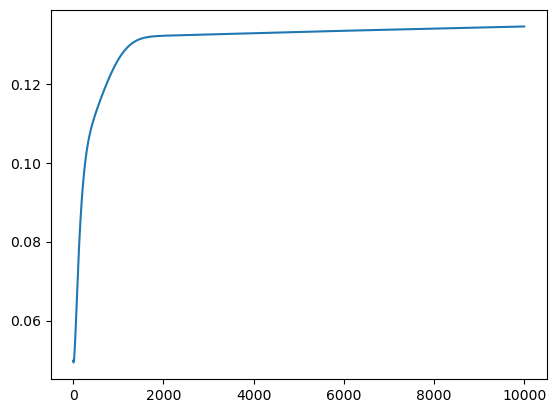

In [23]:
plt.plot(norm_params2(merge_dict(results_KM2,) 
                      ,simulation))

# Second test: No fixed parameter but more data for training

In [21]:
print(pde_resKM.trainables_str())

sigma_u: 1.10000 sigma_v: 0.20000 mu_u: 1.10000 rho_u: 1.10000 
rho_v: 0.12500 


In [22]:
pattern.params

{'D_u': 0.1,
 'D_v': 1.0,
 'kappa_u': 1.0,
 'rho_u': 0.4,
 'mu_u': 0.1,
 'sigma_u': 0.0,
 'rho_v': 1.5,
 'sigma_v': 0.1}

In [23]:
def loss(u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t, params):
    D_u = params["D_u"]
    D_v = params["D_v"]
    sigma_u = params["sigma_u"]
    sigma_v = params["sigma_v"]
    mu_u = params["mu_u"]
    rho_u = params["rho_u"]
    rho_v = params["rho_v"]
    kappa_u = params["kappa_u"]
    
    f = u * u * v / (1.0 + kappa_u * u * u)
    f_u = (D_u * (u_xx + u_yy) 
           + rho_u * f 
           - mu_u * u 
           + sigma_u
           - u_t)
    f_v =( D_v * (v_xx + v_yy)
         - rho_v * f 
         + sigma_v
         - v_t)
    return (f_u, f_v, f, D_u * (u_xx + u_yy) , D_v * (v_xx + v_yy))


def RMSE_loss(u, u_xx, u_yy, u_t, v,  v_xx, v_yy, v_t, params):
    f_u, f_v, _, _ , _ = loss(u,  u_xx, u_yy, u_t, v,  v_xx, v_yy, v_t, params)
    return np.sqrt( np.mean(np.concatenate([f_u, f_v])**2) )

u_ac = pattern.dataset['obs_output'][:, 0]
v_ac = pattern.dataset['obs_output'][:, 1]
u_xx_ac = pattern.dataset['der_u'][0,:]  
u_yy_ac = pattern.dataset['der_u'][1,:]
u_t_ac = pattern.dataset['der_u'][2,:]
v_xx_ac = pattern.dataset['der_v'][0,:]  
v_yy_ac = pattern.dataset['der_v'][1,:]
v_t_ac = pattern.dataset['der_v'][2,:]
u_diff_ac = (u_xx_ac + u_yy_ac)
v_diff_ac = (v_xx_ac + v_yy_ac)

test_X = obs_X[:,:3].astype(np.float32)
_, u,  u_xx, u_yy, u_t, v,  v_xx, v_yy, v_t = derivatives(pinnKM, test_X)

u_diff = (u_xx + u_yy)
v_diff = (v_xx + v_yy)

params_ac = pattern.params
params = {'D_u': pde_resKM.D_u.get_value(test_d),
          'D_v': pde_resKM.D_v.get_value(test_d),
          'sigma_u': pde_resKM.sigma_u.get_value(test_d),
          'sigma_v': pde_resKM.sigma_v.get_value(test_d),
          'mu_u': pde_resKM.mu_u.get_value(test_d),
          'rho_u': pde_resKM.rho_u.get_value(test_d),
          'rho_v': pde_resKM.rho_v.get_value(test_d),
          'kappa_u': pde_resKM.kappa_u.get_value(test_d) 
         }


In [24]:
print(f"Model pred RMSE:{np.sqrt(np.mean(np.concatenate([u-u_ac, v-v_ac])**2))}")
print("#############################")
print(f"Residual RMSE - numeric model: {RMSE_loss(u_ac, u_xx_ac, u_yy_ac, u_t_ac,v_ac, v_xx_ac, v_yy_ac, v_t_ac, params_ac)}")
print("------")
print(f"Residual RMSE - effect of u,v: {RMSE_loss(u, u_xx_ac, u_yy_ac, u_t_ac, v, v_xx_ac, v_yy_ac, v_t_ac, params_ac)}")
print(f"Residual RMSE - effect of autograd: {RMSE_loss(u_ac, u_xx, u_yy, u_t, v_ac, v_xx, v_yy, v_t, params_ac)}")
print(f"Residual RMSE - effect of estimate: {RMSE_loss(u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t, params_ac)}")
print("#############################")
print(f"Residual RMSE - numeric model at estimated params: {RMSE_loss(u_ac, u_xx_ac, u_yy_ac, u_t_ac, v_ac, v_xx_ac, v_yy_ac, v_t_ac, params)}")
print("------")
print(f"Residual RMSE - effect of u,v: {RMSE_loss(u, u_xx_ac, u_yy_ac, u_t_ac, v, v_xx_ac, v_yy_ac, v_t_ac, params)}")
print(f"Residual RMSE - effect of autograd: {RMSE_loss(u_ac, u_xx, u_yy, u_t, v_ac, v_xx, v_yy, v_t, params)}")
print(f"Residual RMSE - effect of estimate: {RMSE_loss(u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t, params)}")


Model pred RMSE:0.0030451337806880474
#############################
Residual RMSE - numeric model: 4.3835561095844415e-06
------
Residual RMSE - effect of u,v: 0.0011442821705713868
Residual RMSE - effect of autograd: 0.0290346909314394
Residual RMSE - effect of estimate: 0.02872094325721264
#############################
Residual RMSE - numeric model at estimated params: 0.6256160140037537
------
Residual RMSE - effect of u,v: 0.6262577772140503
Residual RMSE - effect of autograd: 0.6203256845474243
Residual RMSE - effect of estimate: 0.620968759059906


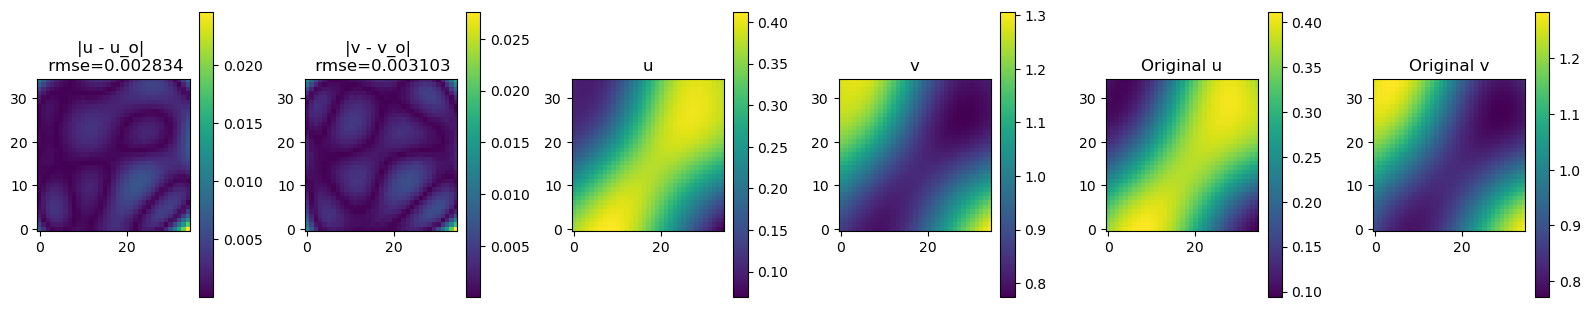

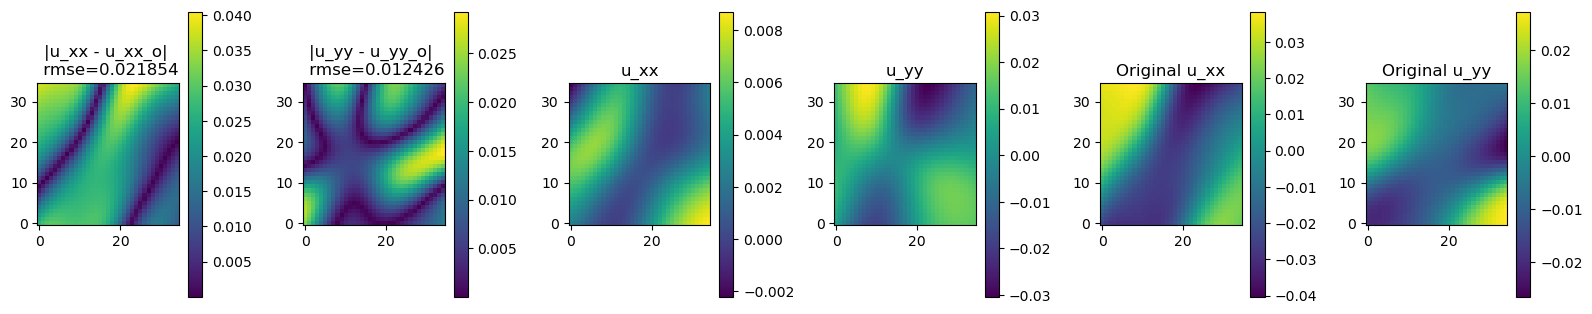

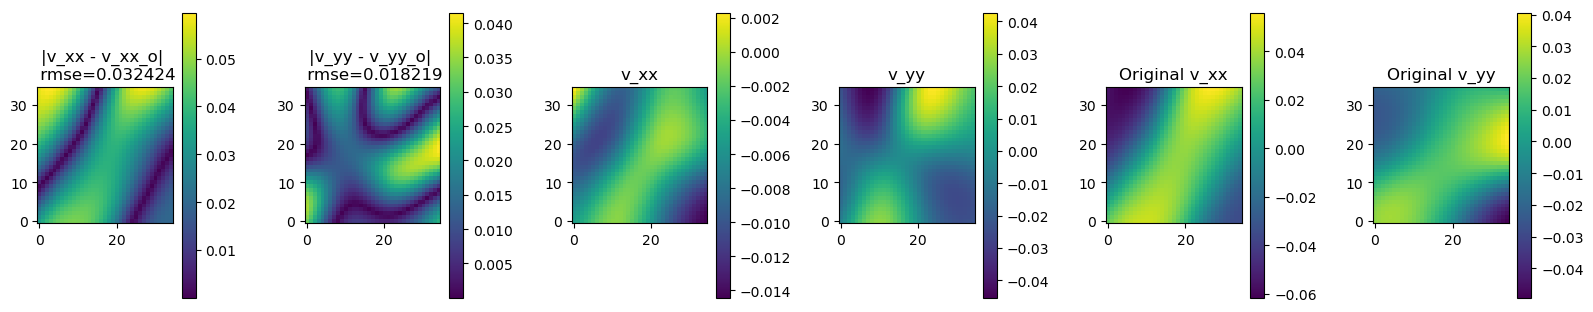

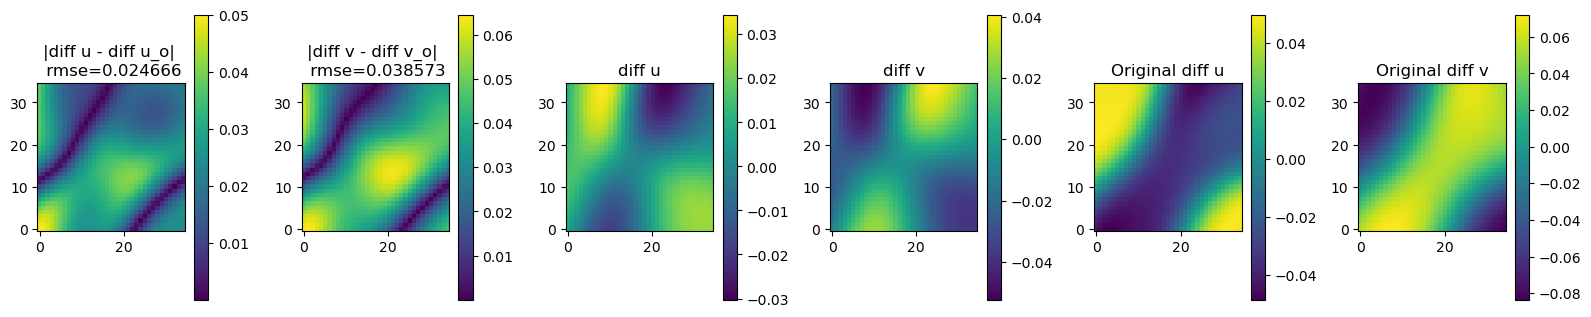

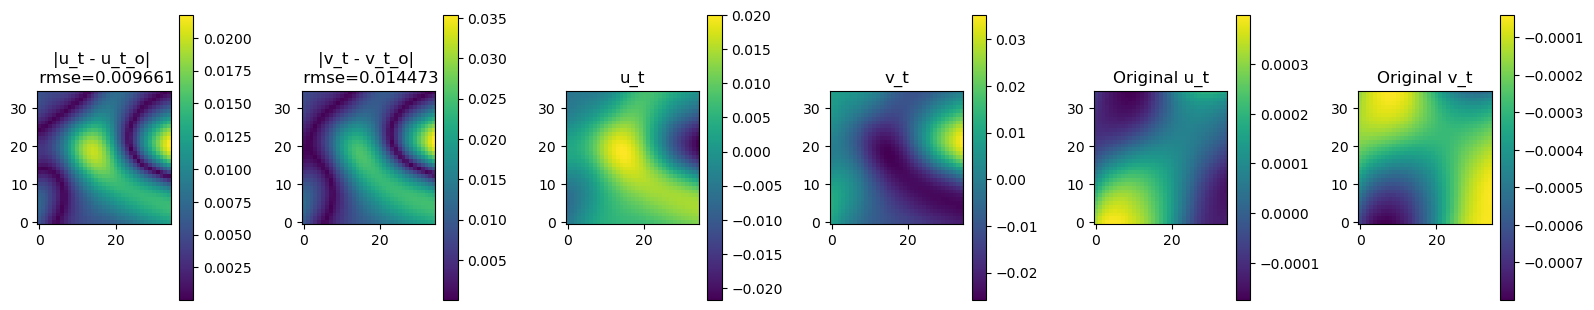

In [25]:
def to_2D(m):
    if isinstance(m, np.ndarray):
        return m[block_size:].reshape(block_x, block_y).T
    else:
        return m.numpy()[block_size:].reshape(block_x, block_y).T

p(to_2D(u), to_2D(v), to_2D(u_ac), to_2D(v_ac))
p(to_2D(u_xx), to_2D(u_yy), to_2D(u_xx_ac), to_2D(u_yy_ac), "u_xx", "u_yy")
p(to_2D(v_xx), to_2D(v_yy), to_2D(v_xx_ac), to_2D(v_yy_ac), "v_xx", "v_yy")
p(to_2D(u_diff), to_2D(v_diff), to_2D(u_diff_ac), to_2D(v_diff_ac), "diff u", "diff v")
p(to_2D(u_t), to_2D(v_t), to_2D(u_t_ac), to_2D(v_t_ac), "u_t", "v_t")

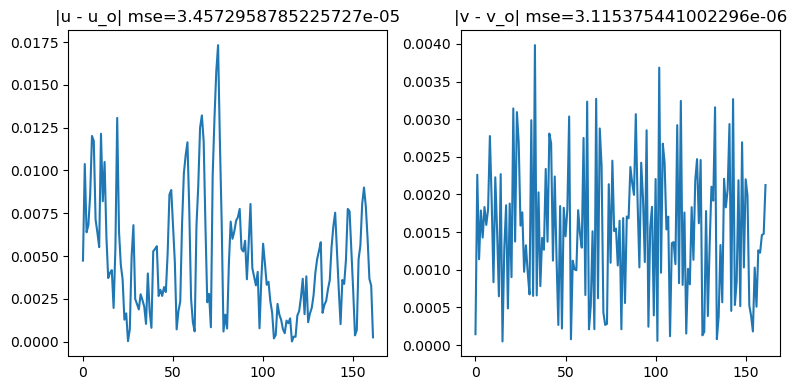

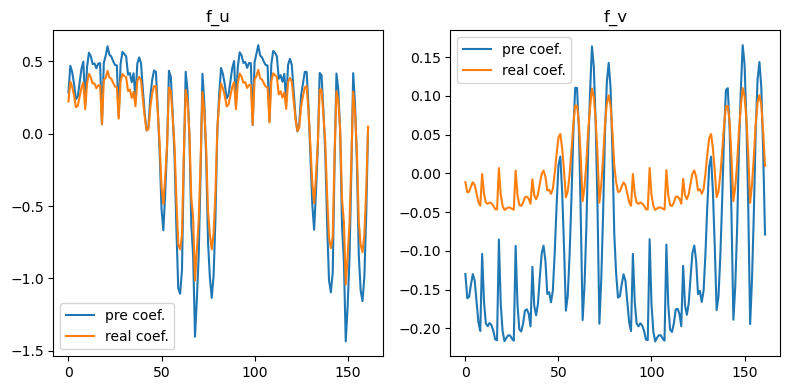

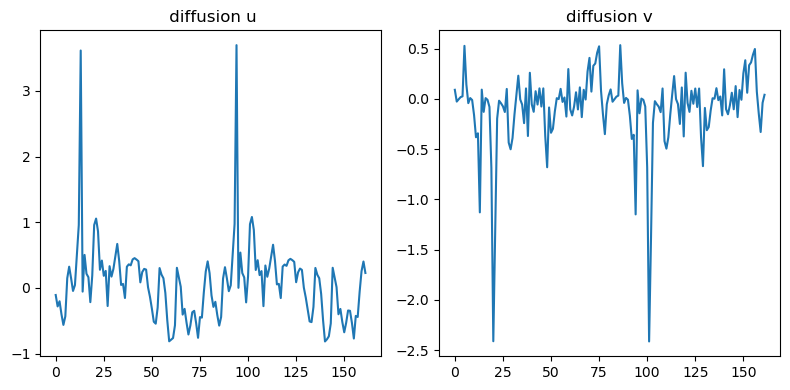

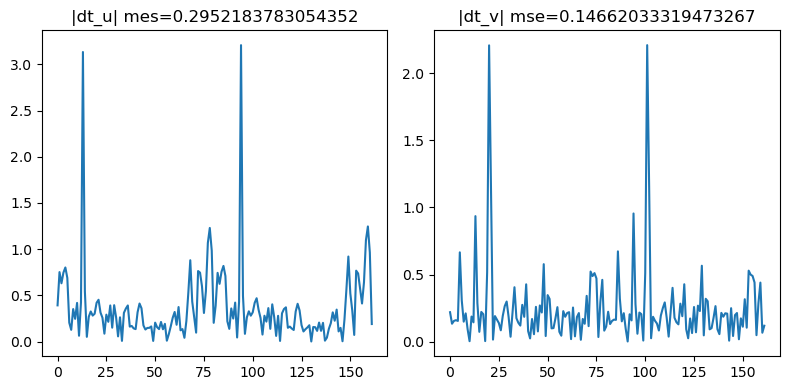

In [32]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
mse = np.mean((u.numpy() - obs_X[:,3])**2)
plt.title(f"|u - u_o| mse={mse}")
plt.plot(np.abs(u.numpy() - obs_X[:,3]))
plt.subplot(122)
mse = np.mean((v.numpy() - obs_X[:,4])**2)
plt.title(f"|v - v_o| mse={mse}")
plt.plot(np.abs(v.numpy() - obs_X[:,4]))
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("f_u")
plt.plot(f_u.numpy(), label="pre coef.")
plt.plot(f_u_real.numpy(), label="real coef.")
plt.legend()
plt.subplot(122)
plt.title("f_v")
plt.plot(f_v.numpy(), label="pre coef.")
plt.plot(f_v_real.numpy(), label="real coef.")
plt.legend()
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title(" diffusion u")
plt.plot(diffusion_u.numpy())
plt.subplot(122)
plt.title("diffusion v")
plt.plot(diffusion_v.numpy())
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
mse = np.mean(d_t_u.numpy()**2)
plt.title(f"|dt_u| mes={mse}")
plt.plot(np.abs(d_t_u.numpy()))
plt.subplot(122)
mse = np.mean(d_t_v.numpy()**2)
plt.title(f"|dt_v| mse={mse}")
plt.plot(np.abs(d_t_v.numpy()))
plt.tight_layout()
plt.show()



In [33]:
from scipy.optimize import lsq_linear

In [41]:
n = ds.sizes[0]
b = np.r_[(simulation.Ds[0]*(u_xx + u_yy)).numpy() - u_t.numpy(), 
          (simulation.Ds[1]*(v_xx + v_yy)).numpy()  - v_t.numpy()]
#b =(-simulation.Ds[0]*(u_xx + u_yy)).numpy() - u_t.numpy()
#b =(-simulation.Ds[1]*(v_xx + v_yy)).numpy() - v_t.numpy()

A = np.vstack((np.c_[f.numpy(), -u.numpy(), [1]*n, [0]*n, [0]*n],
               np.c_[[0]*n, [0]*n, [0]*n, -f.numpy(), [1]*n]))
#A = np.c_[f.numpy(), -u.numpy(), [1]*n]
#A = np.c_[-f.numpy(), [1]*n]


In [42]:
res = lsq_linear(A, b, bounds=(0, np.inf), lsq_solver='lsmr',verbose=1, tol=1e-20, 
                 max_iter=10000,
                 lsmr_tol='auto')#, method='bvls')
res

The maximum number of iterations is exceeded.
Number of iterations 10000, initial cost 1.7845e+03, final cost 1.0483e+03, first-order optimality 1.53e+00.


   active_mask: array([0, 0, 0, 0, 0])
          cost: 1048.3213963234143
           fun: array([-2.20604790e+00, -3.01243164e-01, -1.02924857e+00, -2.08859605e+00,
       -3.26482365e+00, -2.39439672e+00, -8.57518932e-01,  2.27299319e+00,
       -1.99364720e-01, -5.62658813e+00,  2.82539106e-01, -5.80584141e+00,
       -2.50944751e+00, -1.56406309e+00, -1.10250758e-01, -2.02392514e+00,
       -4.34119268e-01, -3.20447745e-01, -8.11718563e+00,  8.98992499e+00,
       -2.13206793e+00,  9.61462114e-01, -2.15291235e+00, -9.09257994e-01,
       -6.72594007e-01, -3.61770286e-01,  7.23203089e-02, -1.13293770e+01,
        9.42442243e+00,  5.19800907e-01,  2.85508296e-01,  3.26380572e-01,
       -2.93906741e+00, -3.71847408e+00, -5.36471252e+00,  1.52815431e+00,
       -1.04339796e+01,  3.55328390e+00,  2.82587334e+00,  5.16299586e-01,
        4.90689700e-01, -2.74155129e+00, -4.06147593e+00, -6.63855164e+00,
        3.77274536e+00, -6.53754049e-01,  2.87811845e+00,  3.54073129e+00,
        6.

In [43]:
print(pde_resKM.trainables_str())

sigma_u: 0.95108 sigma_v: 0.34503 mu_u: 1.16042 rho_u: 1.21230 
rho_v: 0.06073 


In [37]:
simulation.parameters

{'kappa_u': 0.0,
 'mu_u': 1.0,
 'rho_u': 1.0,
 'rho_v': 0.025,
 'sigma_u': 1.0,
 'sigma_v': 0.1}

In [44]:
params = np.array([simulation.parameters['rho_u'], simulation.parameters['mu_u'], 
                   simulation.parameters['sigma_u'],
                   simulation.parameters['rho_v'], simulation.parameters['sigma_v']])



In [45]:
np.mean(((np.dot(A, params)+b))**2)

9.214279933329946

In [46]:
np.mean(((np.dot(A, res.x)+b))**2)

14.182083828237587

In [157]:
obs_X.shape

(2000, 5)